In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import os 
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras 
from keras.callbacks import EarlyStopping,ModelCheckpoint
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tqdm import tqdm



# Loading the dataset

In [2]:
images = []
labels = []
for subfolder in tqdm(os.listdir('/kaggle/input/asl-dataset/asl_dataset')):
    subfolder_path = os.path.join('/kaggle/input/asl-dataset/asl_dataset', subfolder)
    if not os.path.isdir(subfolder_path) or subfolder=='asl_dataset':
        continue
    for image_filename in os.listdir(subfolder_path):
        image_path = os.path.join(subfolder_path, image_filename)
        images.append(image_path)
        labels.append(subfolder)

df = pd.DataFrame({'image': images, 'label': labels})
df

100%|██████████| 37/37 [00:00<00:00, 122.65it/s]


image label
0     /kaggle/input/asl-dataset/asl_dataset/n/hand2_...     n
1     /kaggle/input/asl-dataset/asl_dataset/n/hand1_...     n
2     /kaggle/input/asl-dataset/asl_dataset/n/hand2_...     n
3     /kaggle/input/asl-dataset/asl_dataset/n/hand1_...     n
4     /kaggle/input/asl-dataset/asl_dataset/n/hand2_...     n
...                                                 ...   ...
2510  /kaggle/input/asl-dataset/asl_dataset/j/hand4_...     j
2511  /kaggle/input/asl-dataset/asl_dataset/j/hand1_...     j
2512  /kaggle/input/asl-dataset/asl_dataset/j/hand1_...     j
2513  /kaggle/input/asl-dataset/asl_dataset/j/hand1_...     j
2514  /kaggle/input/asl-dataset/asl_dataset/j/hand1_...     j

[2515 rows x 2 columns]

# Generating random sign languages for training and testing


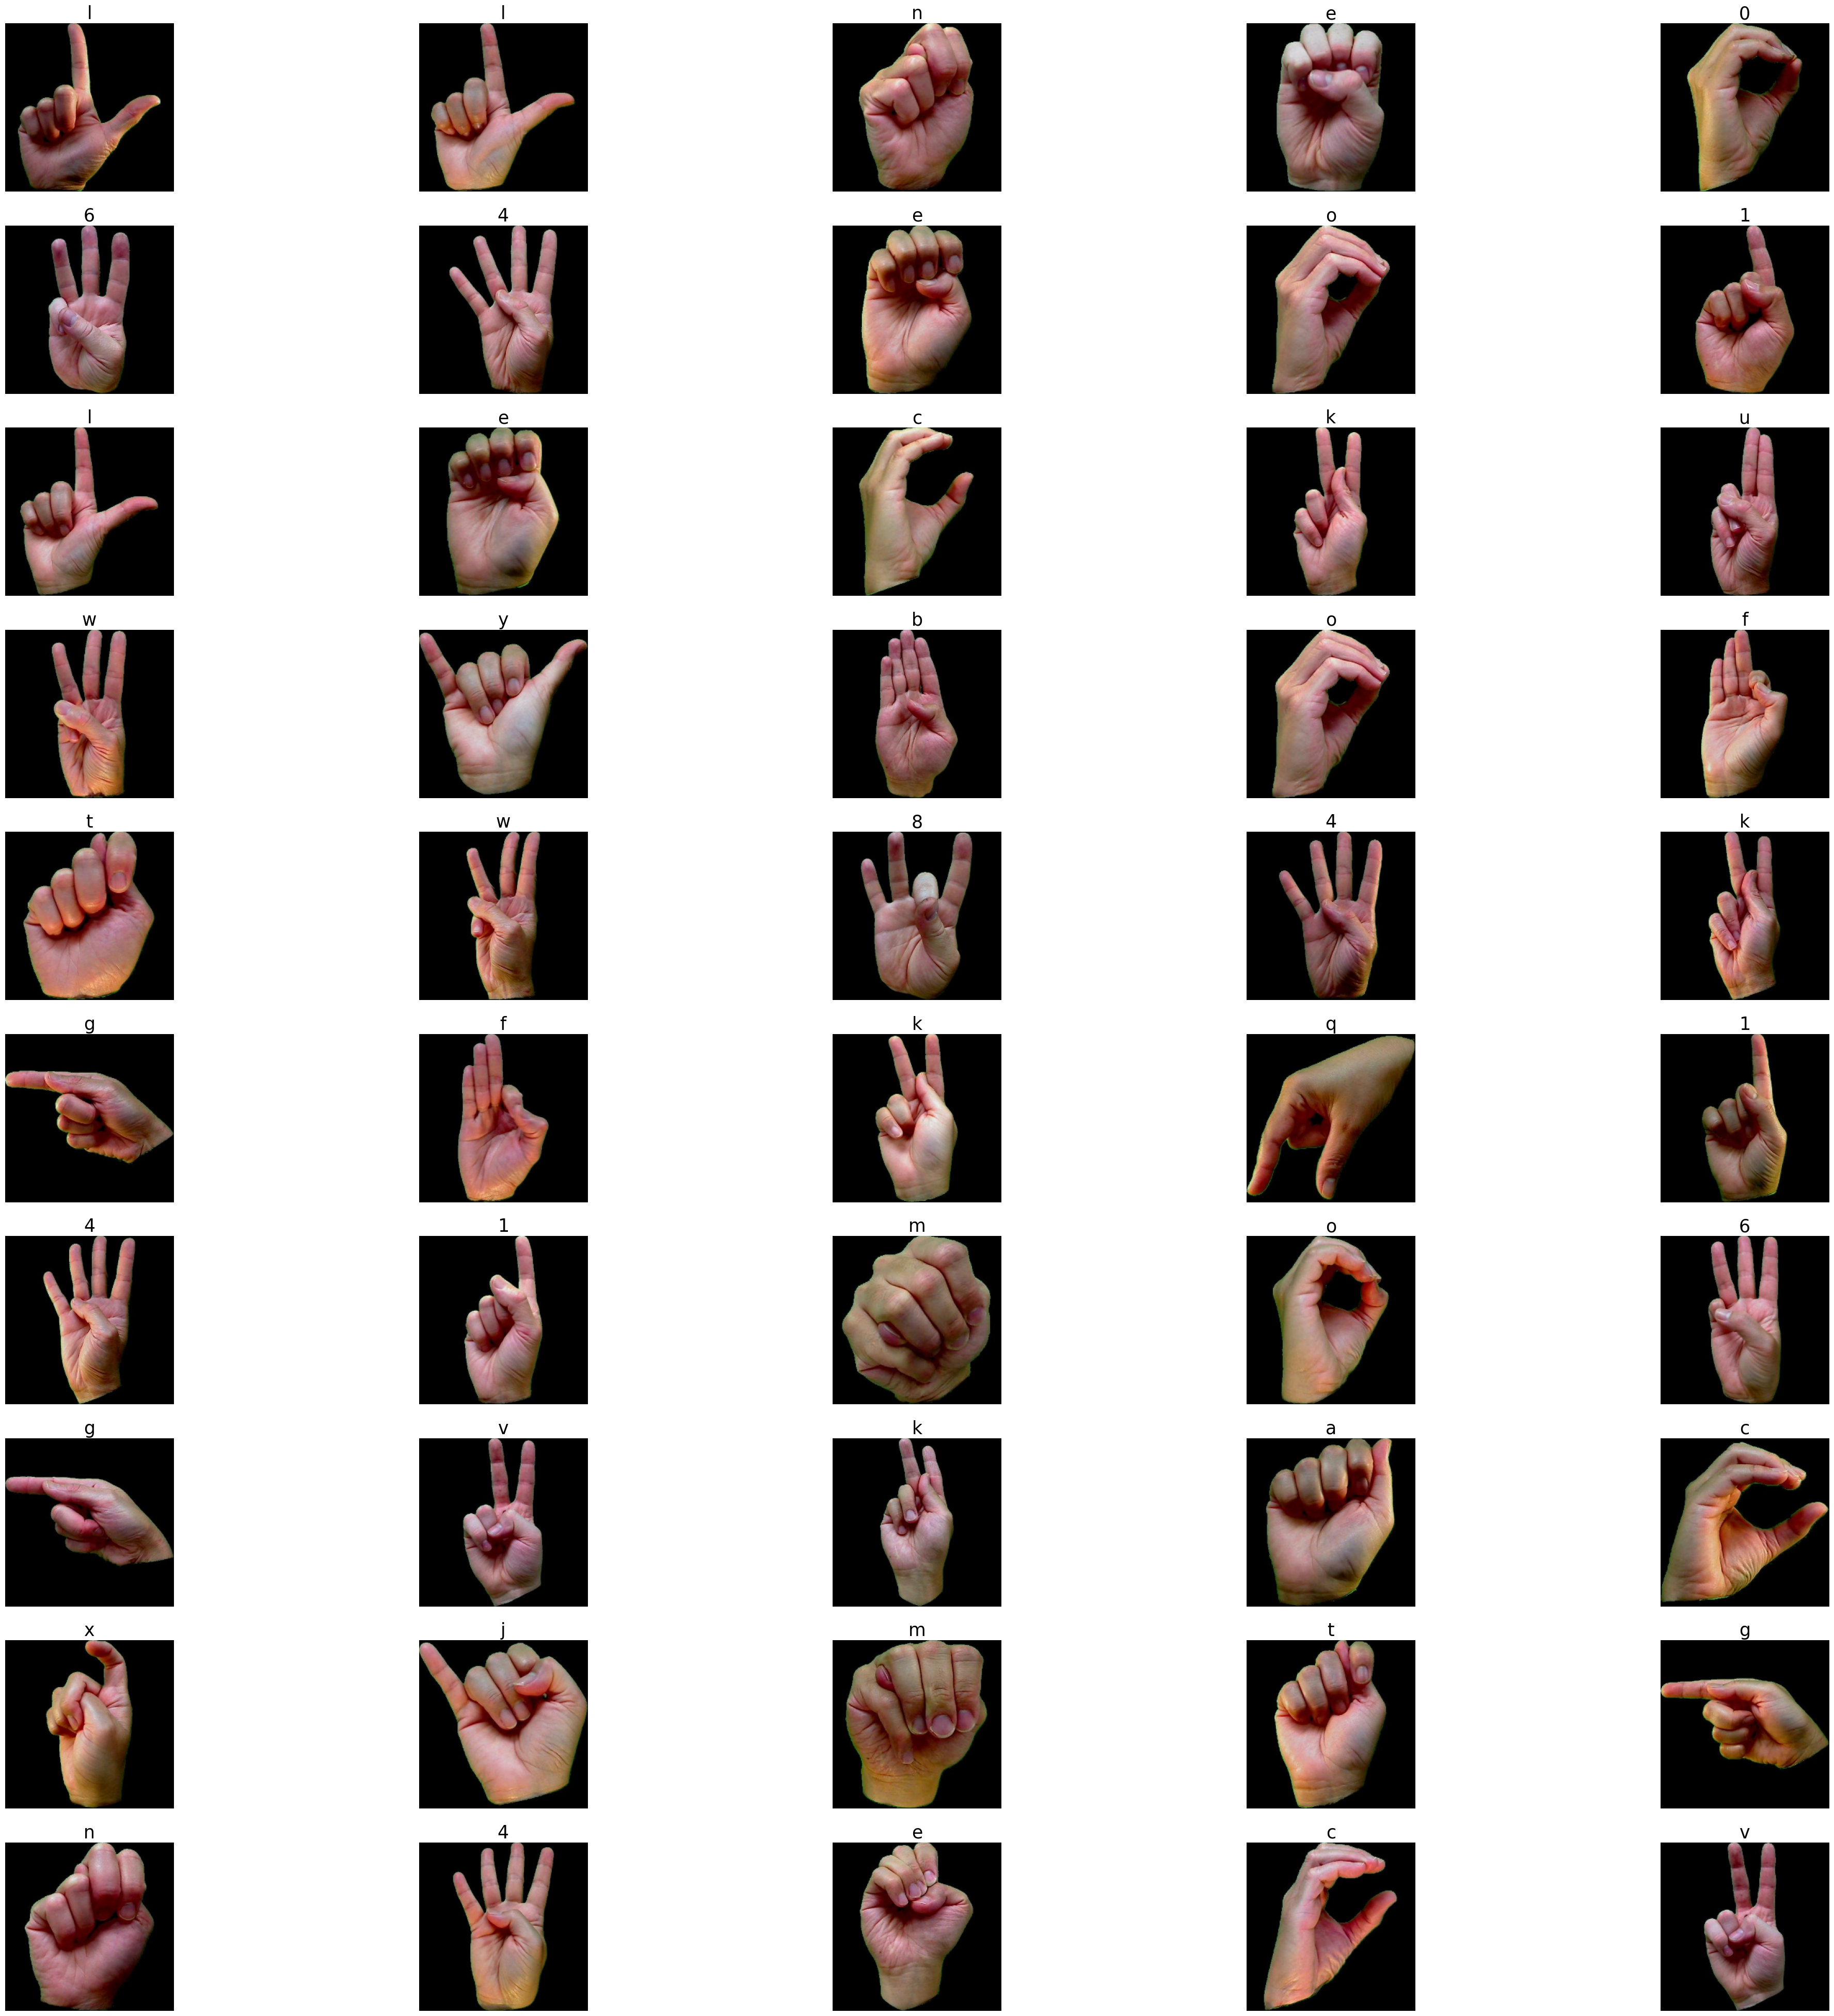

In [3]:
plt.figure(figsize=(50,50))
for n,i in enumerate(np.random.randint(0,len(df),50)):
    plt.subplot(10,5,n+1)
    img=cv2.imread(df.image[i])
    img=cv2.resize(img,(224,224))
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.title(df.label[i],fontsize=25)

In [4]:
X_train, X_test1, y_train, y_test1 = train_test_split(df['image'], df['label'], test_size=0.3, random_state=42,shuffle=True,stratify=df['label'])
X_val, X_test, y_val, y_test = train_test_split(X_test1,y_test1, test_size=0.5, random_state=42,shuffle=True,stratify=y_test1)
df_train = pd.DataFrame({'image': X_train, 'label': y_train})
df_test = pd.DataFrame({'image': X_test, 'label': y_test})
df_val = pd.DataFrame({'image': X_val, 'label': y_val})

# Train, test and validation split

In [5]:
image_size = (224,224)
batch_size = 32
datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True
)
train_generator = datagen.flow_from_dataframe(
    df_train,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)
test_generator = datagen.flow_from_dataframe(
    df_test,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)
val_generator = datagen.flow_from_dataframe(
    df_val,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

Found 1760 validated image filenames belonging to 36 classes.
Found 378 validated image filenames belonging to 36 classes.
Found 377 validated image filenames belonging to 36 classes.


# Using Mobile net model for training

In [6]:
base_model = tf.keras.applications.MobileNet(
    input_shape=(224,224,3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

model = keras.models.Sequential()
model.add(base_model)
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256, activation=tf.nn.relu))
model.add(keras.layers.Dropout(.3))
model.add(keras.layers.Dense(36, activation=tf.nn.softmax))
model.build(input_shape=(None,224,224,3))
model.summary()

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_224 (Functional) │ (None, 7, 7, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    12,845,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 36)             │         9,252 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,083,428 (61.35 MB)

 Trainable params: 12,854,564 (49.04 MB)

 Non-trainable params: 3,228,864 (12.32 MB)

# Visual representation of model

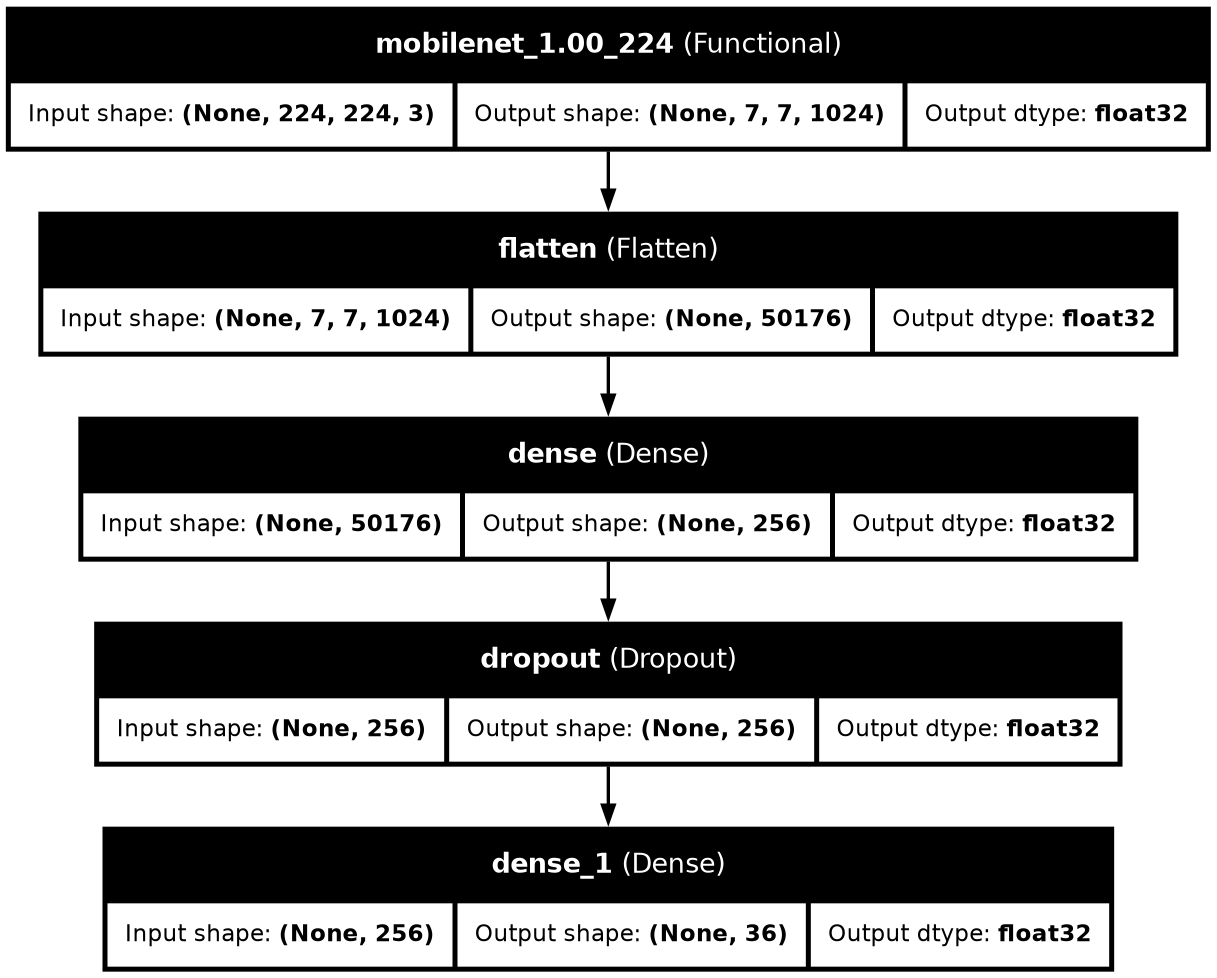

In [7]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=120)

In [8]:
early_stopping_cb =EarlyStopping(patience=5, restore_best_weights=True)
model.compile(optimizer ='adam', loss='categorical_crossentropy', metrics=['accuracy'])
hist = model.fit(train_generator, epochs=20, validation_data=val_generator, callbacks=[early_stopping_cb])

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1739305936.376145      69 service.cc:145] XLA service 0x78a590002240 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1739305936.376217      69 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 1/55 ━━━━━━━━━━━━━━━━━━━━ 8:04 9s/step - accuracy: 0.0000e+00 - loss: 5.7445

I0000 00:00:1739305941.153248      69 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


55/55 ━━━━━━━━━━━━━━━━━━━━ 23s 261ms/step - accuracy: 0.3031 - loss: 11.3204 - val_accuracy: 0.7772 - val_loss: 0.8431
Epoch 2/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - accuracy: 0.7018 - loss: 0.9684 - val_accuracy: 0.9019 - val_loss: 0.4053
Epoch 3/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.8074 - loss: 0.5964 - val_accuracy: 0.9310 - val_loss: 0.2109
Epoch 4/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.8830 - loss: 0.3337 - val_accuracy: 0.9019 - val_loss: 0.3051
Epoch 5/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.9009 - loss: 0.2992 - val_accuracy: 0.9469 - val_loss: 0.1582
Epoch 6/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.9071 - loss: 0.2551 - val_accuracy: 0.9284 - val_loss: 0.2552
Epoch 7/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.9170 - loss: 0.2512 - val_accuracy: 0.9496 - val_loss: 0.2067
Epoch 8/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.9181 - loss: 0.2251 - val_accuracy: 0.9496 - val_loss:

In [9]:
hist=pd.DataFrame(hist.history)
hist

accuracy      loss  val_accuracy  val_loss
0   0.436932  5.776202      0.777188  0.843112
1   0.748864  0.818578      0.901857  0.405303
2   0.819886  0.548903      0.931035  0.210926
3   0.886364  0.341417      0.901857  0.305140
4   0.899432  0.285361      0.946950  0.158240
5   0.900568  0.293421      0.928382  0.255179
6   0.921591  0.235459      0.949602  0.206734
7   0.914205  0.244270      0.949602  0.153092
8   0.923864  0.232362      0.960212  0.161642
9   0.940909  0.161763      0.965517  0.135130
10  0.948864  0.154359      0.970822  0.119929
11  0.934091  0.204552      0.965517  0.137216
12  0.947159  0.154383      0.962865  0.146439
13  0.955114  0.144420      0.962865  0.149131
14  0.952841  0.142008      0.976127  0.099994
15  0.951136  0.154590      0.960212  0.213485
16  0.967614  0.111984      0.965517  0.122370
17  0.961364  0.131235      0.968170  0.157926
18  0.947159  0.178408      0.968170  0.139530
19  0.960795  0.136648      0.968170  0.128715

# Plotting training and validation loss and accuracy

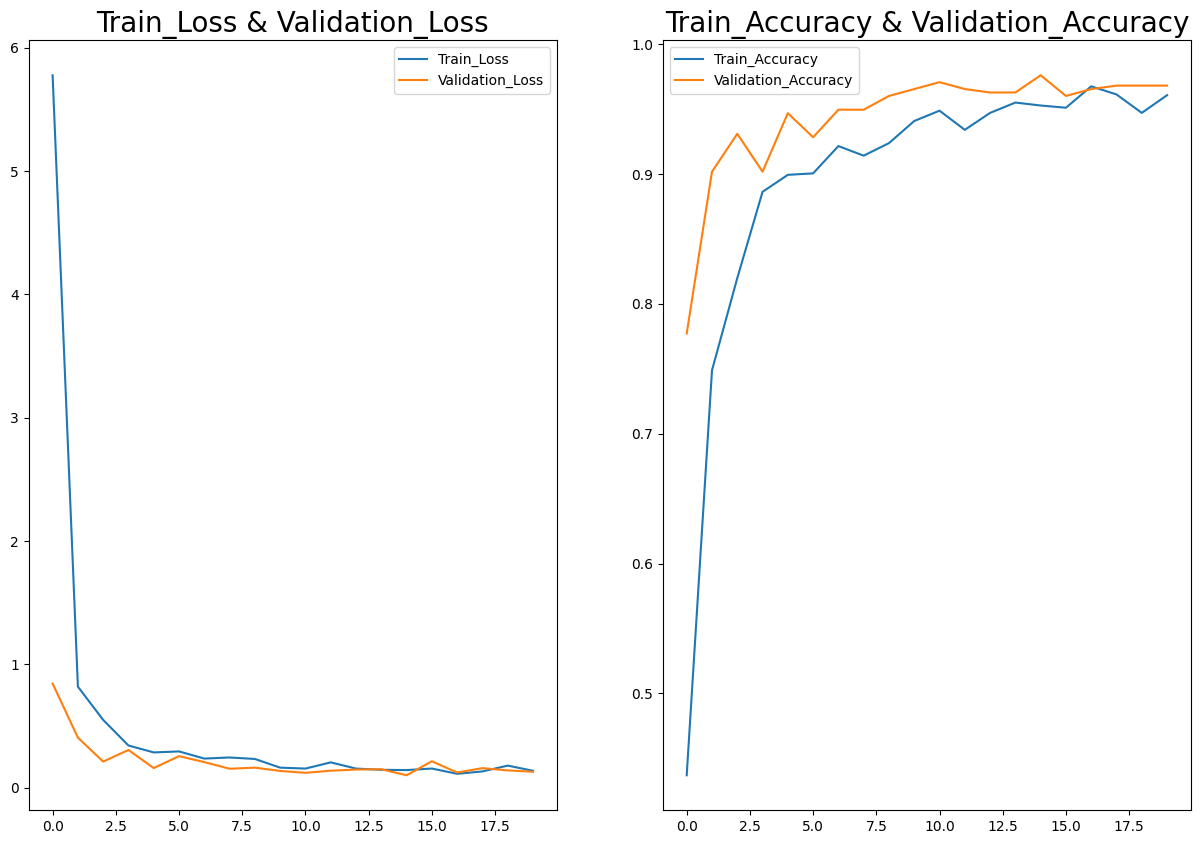

In [10]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.plot(hist['loss'],label='Train_Loss')
plt.plot(hist['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist['accuracy'],label='Train_Accuracy')
plt.plot(hist['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()

In [11]:
score, acc= model.evaluate(test_generator)
print('Test Loss =', score)
print('Test Accuracy =', acc)

 2/12 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9922 - loss: 0.0614 

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 332ms/step - accuracy: 0.9763 - loss: 0.1000
Test Loss = 0.10332656651735306
Test Accuracy = 0.976190447807312


# The model's accuracy is 97.62%

In [12]:
y_test =test_generator.classes
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions,axis=1)
y_test = np.ravel(y_test)
y_pred = np.ravel(y_pred)
df = pd.DataFrame({'Actual': y_test, 'Prediction': y_pred})
df

12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 181ms/step


Actual  Prediction
0        17          17
1        29          29
2         0          24
3         6           6
4        11          11
..      ...         ...
373      30          30
374      35          35
375      10          10
376      20          20
377       9           9

[378 rows x 2 columns]

# Predictions of some sign languages

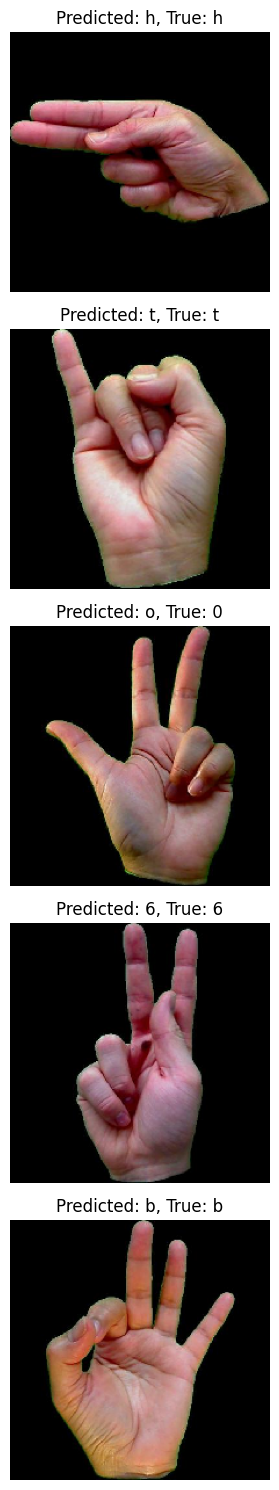

In [13]:
y_true = test_generator.classes  # True labels from test generator
class_labels = list(test_generator.class_indices.keys())  # Class names
num_samples = 5  # Number of samples to display

# Generate predictions
y_pred = np.argmax(predictions, axis=1)  # Assuming predictions are probabilistic outputs

# Plot predictions vs true labels for sample images
plt.figure(figsize=(15, num_samples * 3))
for i in range(num_samples):
    img, true_label = test_generator[i][0], y_true[i]
    predicted_label = y_pred[i]
    
    plt.subplot(num_samples, 2, 2*i + 1)
    plt.imshow(img[0])  # Display image
    plt.axis('off')
    plt.title(f"Predicted: {class_labels[predicted_label]}, True: {class_labels[true_label]}")

plt.tight_layout()
plt.show()

In [14]:
ClassificationReport = classification_report(y_test,y_pred)
print('Classification Report is : ', ClassificationReport )

Classification Report is :                precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.92      1.00      0.96        11
           2       0.77      0.91      0.83        11
           3       1.00      1.00      1.00        11
           4       1.00      1.00      1.00        10
           5       1.00      1.00      1.00        10
           6       0.92      1.00      0.96        11
           7       1.00      1.00      1.00        11
           8       1.00      1.00      1.00        10
           9       1.00      1.00      1.00        10
          10       1.00      1.00      1.00        11
          11       0.92      1.00      0.96        11
          12       1.00      1.00      1.00        10
          13       1.00      1.00      1.00        10
          14       1.00      1.00      1.00        11
          15       1.00      1.00      1.00        10
          16       1.00      1.00      1.00        10

In [15]:
model.save("model.h5")